# Analysis of DeepPath Experiments
This notebook documents our analysis of performance results from various experiments ran on DeepPath models

## Setup

In [1]:
# Packages/Helper Function Import
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import deeppath_parsers as dp
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Directory Constants
output_dir = Path("work/output/")
int_dir = Path("work/intermediate")

In [3]:
# Helper function for loading many studies
def load_studies(studies,labels):
    # Parse slide probs
    slide_probs = pd.concat({
        study.stem:pd.DataFrame(dp.parse_slide_probs(study / "auc" / "out2_perSlideStats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    slide_probs["group"] = slide_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    slide_probs["group"].fillna("Control",inplace=True)
    slide_probs["study"] = pd.Categorical(slide_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    slide_probs.sort_values(["study","class"],inplace=True)
    slide_probs["study"] = slide_probs["study"].astype(str)
    # Parse tile probs
    tile_probs =  pd.concat({
        study.stem:pd.DataFrame(dp.parse_tile_probs(study / "out_filename_Stats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    tile_probs["group"] = tile_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    tile_probs["group"].fillna("Control",inplace=True)
    tile_probs["study"] = pd.Categorical(tile_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    tile_probs.sort_values(["study","class"],inplace=True)
    tile_probs["study"] = tile_probs["study"].astype(str)
    tile_probs.drop_duplicates(inplace=True)
    #Parse AUCs
    auc = pd.concat({
        study.stem:pd.DataFrame(dp.parse_auc_file(study / "auc_summary.txt"))
        for study in studies
    },names=["study"]).reset_index()
    auc["group"] = auc["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    auc["group"].fillna("Control",inplace=True)
    auc["study"] =pd.Categorical(auc["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    auc.sort_values(["study","class"],inplace=True)
    auc["study"] = auc["study"].astype(str)
    auc["ci_upper"] = auc["ci_upper"] - auc["auc"]
    auc["ci_lower"] = auc["auc"] - auc["ci_lower"]
    slide_auc = auc[auc.type=="slide"]
    tile_auc = auc[auc.type=="tile"]
    return slide_probs.drop_duplicates(),tile_probs,slide_auc,tile_auc
# Helper function for plotting with error bars
# Adapted from : https://stackoverflow.com/questions/45875143/seaborn-making-barplot-by-group-with-asymmetrical-custom-error-bars
def auc_error_bar_plot(x,y,hue,lb,ub,label_order,**kwargs):
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=hue, values=lb)
    errHi = data.pivot(index=x, columns=hue, values=ub)
    err = []
    for col in errLo:
        err.append([errLo[col].values, errHi[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=hue, values=y)
    p = p.reindex(label_order).dropna(axis=0)
    fig = p.plot(kind='bar',yerr=err,ax=plt.gca(), **kwargs)
    return fig

In [4]:
# Phase 1 Study Labels
phase1_labels = {
    "exp_bubbles_20": "B 20%",
    "exp_bubbles_100": "B 100%",
    "exp_fold_20": "F 20%",
    "exp_illumination_10": "I 10%",
    "exp_illumination_50": "I 50%",
    "exp_illumination_100": "I 100%",
    "exp_marker_50": "M 50%",
    "exp_marker_90": "M 90%",
    "exp_sectioning_15": "Se 15%",
    "exp_sectioning_30" : "Se 30%",
    "exp_stain_10": "St 10%",
    "exp_stain_30": "St 30%",
    "exp_tear_15": "T 15%",
    "all": "Unperturbed"
}

phase1_studies = list(output_dir.glob("exp_*_*")) + [output_dir / "all"]
phase1_slide_probs, phase1_tile_probs, phase1_slide_auc, phase1_tile_auc = load_studies(phase1_studies,phase1_labels)

## True probability plots

Text(0.5, 0.98, 'Slide Average True Probabilities')

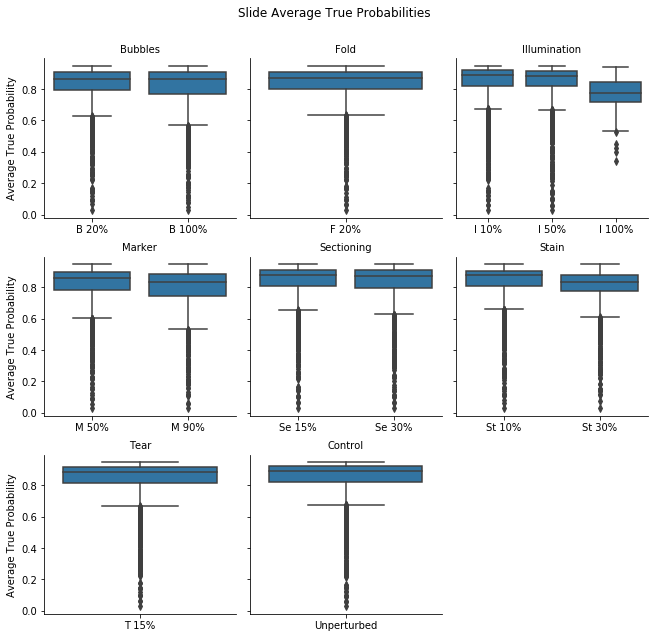

In [5]:
# Average True Prob Overall
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob")
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Slide Average True Probabilities")

Text(0.5, 0.98, 'Slide Average True Probabilities (By Class)')

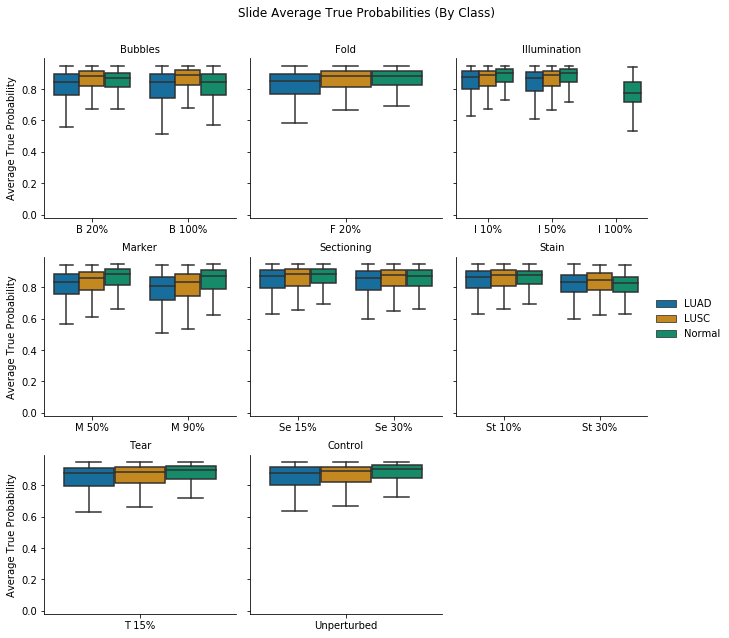

In [6]:
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Slide Average True Probabilities (By Class)")

Text(0.5, 0.98, 'Tile True Probabilities (By Class)')

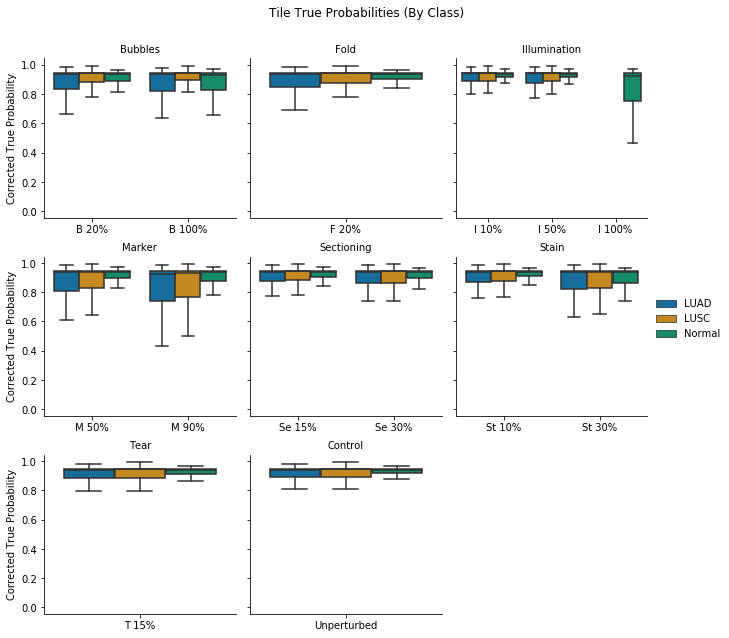

In [7]:
g = sns.FacetGrid(data=phase1_tile_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Tile True Probabilities (By Class)")

## AUC Plots

Text(0.5, 0.98, 'AUC By Tile')

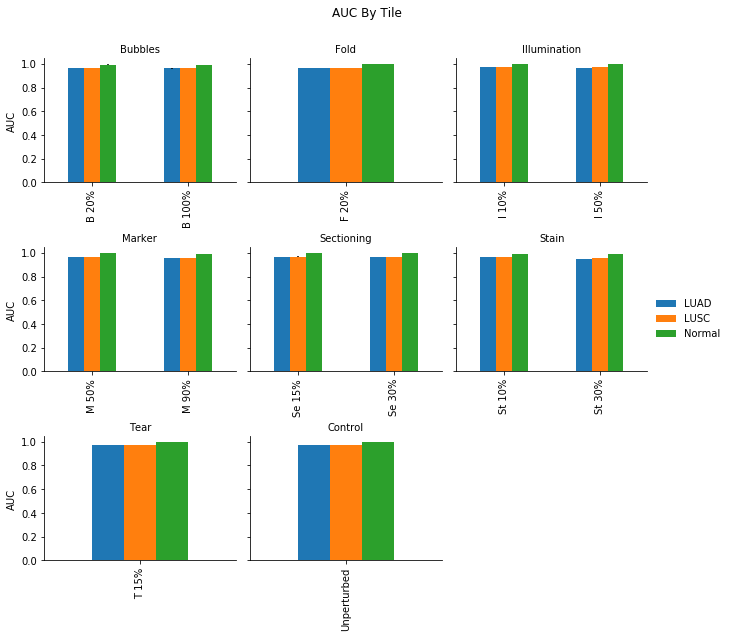

In [8]:
g = sns.FacetGrid(phase1_tile_auc, col="group",sharex=False,col_wrap=3) 
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("AUC By Tile")

Text(0.5, 0.98, 'AUC By Slide')

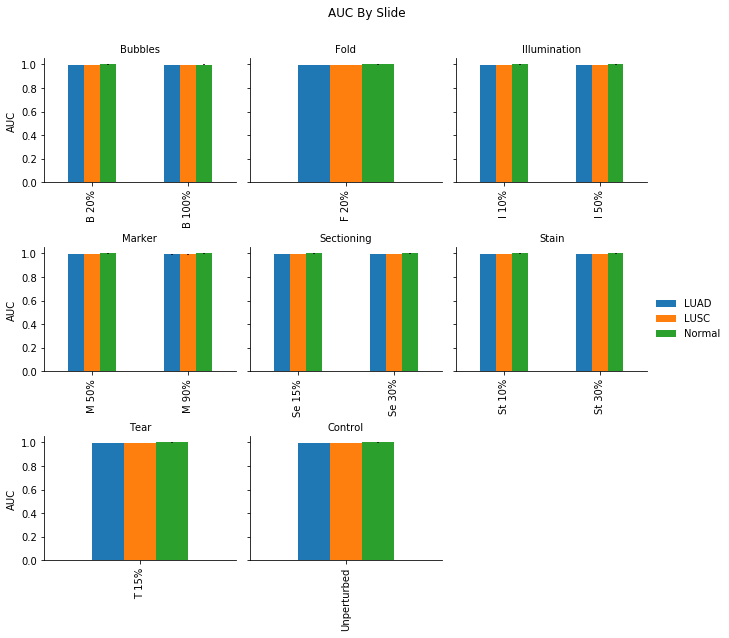

In [9]:
g = sns.FacetGrid(data=phase1_slide_auc,col="group",sharex=False,col_wrap=3)
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("AUC By Slide")

## Threshold analysis

In [10]:
def threshold_analysis(probs,auc):
# Calculate accuracies depending on threshold
    x = probs[["study","group","class","normal_prob","luad_prob","lusc_prob"]].melt(id_vars=["study","group","class"]).rename(columns=  {"class":"true_class"})
    x["prob_class"] = x["variable"].str[:-5]
    y = auc[["study","class","best_thresh"]]
    y["thresh_class"] = y["class"].str.lower()
    y.drop(columns="class",inplace=True)
    merged = x.merge(y,left_on=["study","prob_class"],right_on=["study","thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    study_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    merged = x.merge(y[y["study"]=="Unperturbed"][["thresh_class","best_thresh"]],left_on=["prob_class"],right_on=["thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    ctrl_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    relative_acc = pd.DataFrame({"study_acc":study_thresh_acc,"ctrl_acc":ctrl_thresh_acc}).reindex(phase1_labels.values(),axis=0,level="study").reset_index()
    relative_acc["delta_acc"] = relative_acc["ctrl_acc"] - relative_acc["study_acc"]
    return relative_acc


/home/jeremybk/miniconda3/envs/b590prj/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jeremybk/miniconda3/envs/b590prj/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 0.98, 'Change in Tile Accuracy Due to Threshold Change')

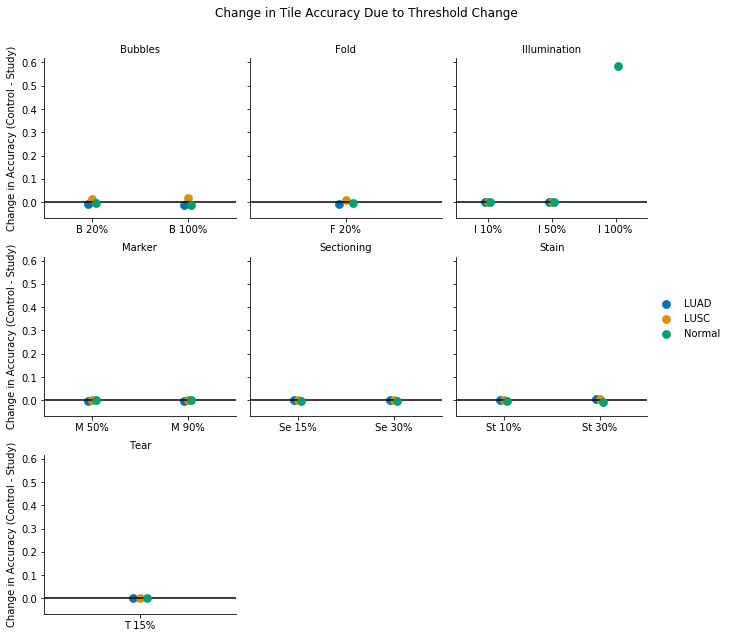

In [11]:
tile_relative_auc = threshold_analysis(phase1_tile_probs,phase1_tile_auc)
g = sns.FacetGrid(tile_relative_auc[tile_relative_auc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Change in Tile Accuracy Due to Threshold Change")


/home/jeremybk/miniconda3/envs/b590prj/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 0.98, 'Change in Slide Accuracy Due to Threshold Change')

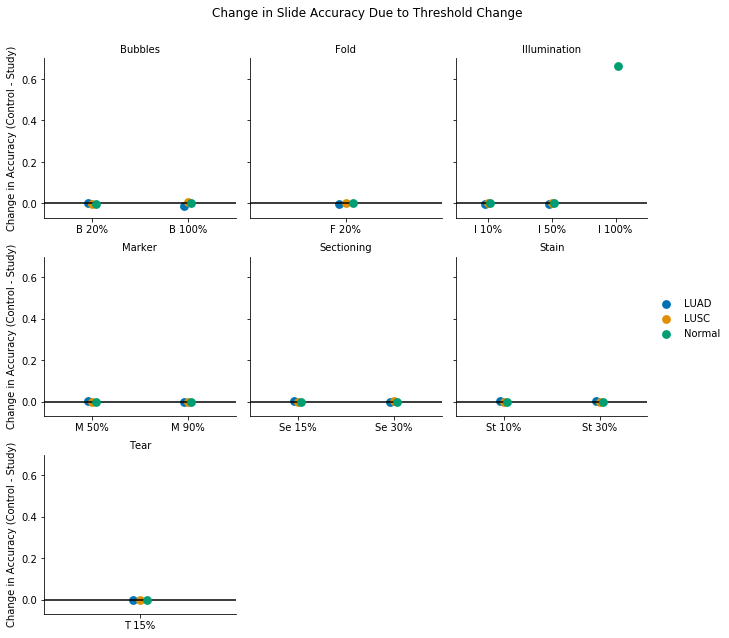

In [12]:
slide_relative_acc = threshold_analysis(phase1_slide_probs,phase1_slide_auc)
g = sns.FacetGrid(slide_relative_acc[slide_relative_acc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Change in Slide Accuracy Due to Threshold Change")


## Modified tile comparisons


In [13]:
mod_tiles = pd.concat({
    label: pd.DataFrame(dp.parse_modified_tile_log(int_dir / study / "log_modified_tiles.txt"),columns=["name","tile"])
    for study,label in phase1_labels.items()
    if study != "all"
},names=["study","prev"],copy=False).reset_index().drop(columns=["prev"]).drop_duplicates()

In [14]:
mod_tiles.shape

(8026387, 3)

In [15]:
mod_tile_prob = mod_tiles.merge(phase1_tile_probs,on=["study","name","tile"],how="inner")

Text(0.5, 0.98, 'Manipulated Tile True Probabilities (By Class)')

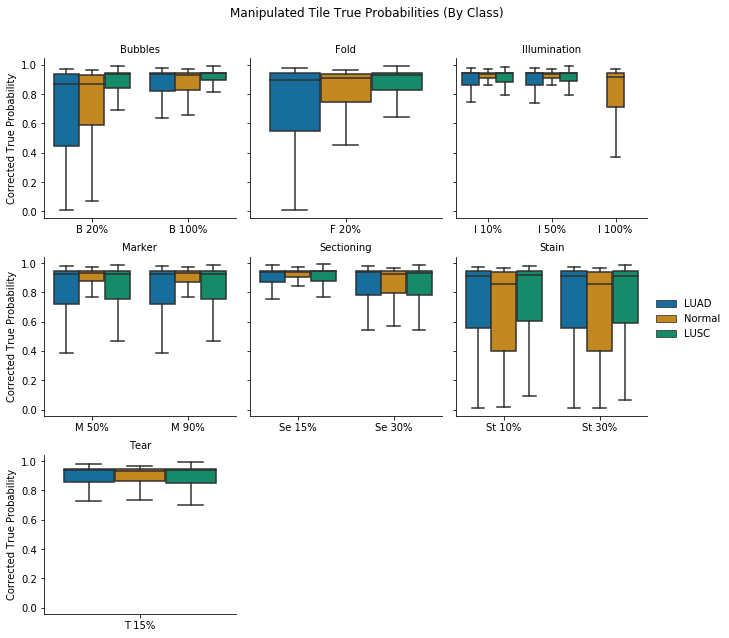

In [16]:
g = sns.FacetGrid(data=mod_tile_prob,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Manipulated Tile True Probabilities (By Class)")

In [17]:
mod_avg_slide_prob = mod_tile_prob.groupby(["group","study","name","class"]).agg({"corrected_true_prob":"mean"}).reset_index()

Text(0.5, 0.98, 'Modified Tile Slide Average True Probabilities (By Class)')

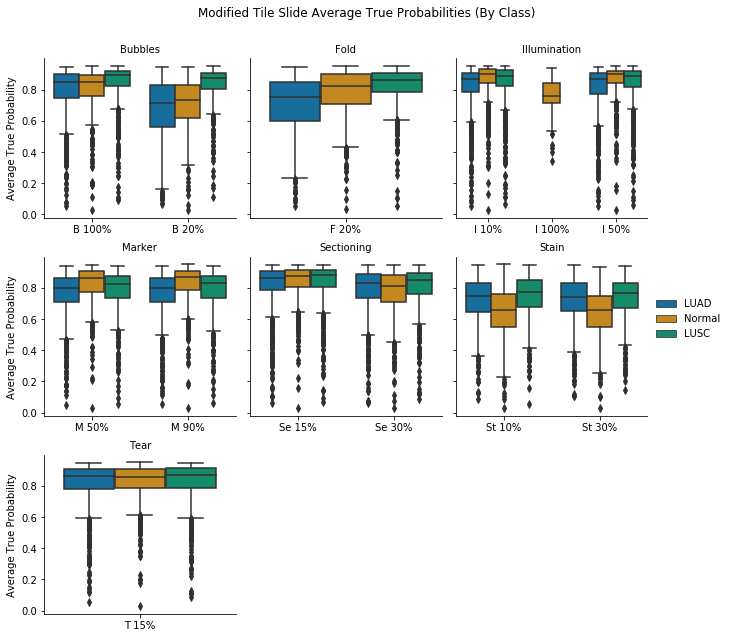

In [18]:
g = sns.FacetGrid(data=mod_avg_slide_prob,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Modified Tile Slide Average True Probabilities (By Class)")

In [19]:
mod_tile_prob["frac"] = mod_tile_prob["study"].str.extract(r"[\w+] ([\d]+%)",expand=False).str.capitalize()

In [20]:
mod_tile_prob.groupby(["frac"]).agg({"group":lambda x: [x.unique()]})

,group
frac,
10%,"[[Illumination, Stain]]"
100%,"[[Bubbles, Illumination]]"
15%,"[[Sectioning, Tear]]"
20%,"[[Bubbles, Fold]]"
30%,"[[Sectioning, Stain]]"
50%,"[[Illumination, Marker]]"
90%,[[Marker]]


In [21]:
mod_tile_diff = mod_tile_prob.\
    groupby(["frac","name","tile","class"]).\
    agg({
        "study":"count",
        "group":lambda x: "-".join(x),
        "corrected_true_prob":lambda x: [np.diff(x)]
    }).\
    query("study>1").\
    reset_index()
mod_tile_diff["diff_prob"]=[np.abs(y[0][0]) for y in mod_tile_diff["corrected_true_prob"]]

In [22]:
mod_tile_diff["diff_prob"]=[np.abs(y[0][0]) for y in mod_tile_diff["corrected_true_prob"]]

Text(0.5, 0.98, 'Difference in prediction probability between perterbations of the same tile')

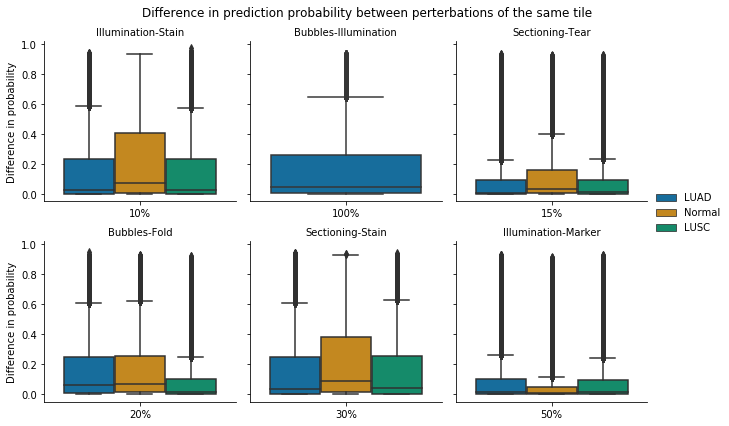

In [23]:
g = sns.FacetGrid(data=mod_tile_diff,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="frac",y="diff_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Difference in probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Difference in prediction probability between perterbations of the same tile")